In [1]:
import torch
import networkx as nx
import numpy as np
import scipy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random

device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [2]:
def ba_gen(n,m):
    while True:  
        yield nx.barabasi_albert_graph(n,m)

def grid_gen(dims):
    while True:
        yield nx.grid_graph(dims)

def caveman_gen(c,k):
    while True:
        yield nx.connected_caveman_graph(c, k)
        
def gnm_gen(n,m):
    while True:
        yield nx.gnm_random_graph(n,m) 

def ws_gen(n,k,p):
    while True:
        yield nx.watts_strogatz_graph(n,k,p) 


def graph_gen():
    generators = [
        gnm_gen(150,200),
        ba_gen(150,2),
        #caveman_gen(6,25),
        #grid_gen((10,15)),
        ws_gen(150,4,0.1),
    ]
    while True: 
        gen = random.choice(generators)
        G = next(gen)
        G = nx.convert_node_labels_to_integers(G)
        yield G
        
next(graph_gen())


In [3]:
class SignalPropagation(torch.nn.Module):
    def __init__(self, sig, momentum=0.999, response_len=10000, tqdm=lambda x:x, device="cpu"):
        super(SignalPropagation, self).__init__()
        self._device = device
        self._a = momentum
        self._len = response_len
        self._sig = sig.to(self._device)
        self._sig_loop = len(sig)
        self._tqdm = tqdm

    def forward(self, A):
        n  = len(A)
        P = torch.ones((n,n)).to(self._device)
        Snew = Sold = S = torch.zeros((1,n)).to(self._device)
        dS = dSold = torch.zeros((n,n)).to(self._device)
        M = torch.zeros((n,n)).to(self._device)

        response = []
        for i in self._tqdm(range(0,self._len)):
            Sold = S
            S = Snew
            dSold = dS
            S += sig[i % (self._sig_loop-1)]
            response.append(S)
            dS = (A / (A.sum(dim=0)+1E-32)).T
            D = torch.diag(S.squeeze())
            dS = D.mm(dS) + self._a*M
            Snew = S + dS.sum(dim=0) - dS.sum(dim=1)
            M = dS
        response = torch.stack(response).squeeze().T
        return response

In [4]:
from torch import nn


class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.double()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        #return F.log_softmax(x, dim=2)
        return x



In [5]:
def eval_graph(G,instrument,lcm,centrality,plt=plt):
    G = nx.convert_node_labels_to_integers(G)
    with torch.no_grad():
        Adj = nx.adjacency_matrix(G).toarray()
        Adj = torch.tensor(Adj).to(device)
        
        #impulse response
        signal = instrument(Adj)

        #listen
        y_pred = lcm(signal.unsqueeze(dim=1).double())
        y_pred = y_pred.squeeze()

        #eval
        y_gt = centrality(G)
        y_gt = [y_gt[i] for i in range(G.number_of_nodes())]
        y_gt = torch.tensor(y_gt).to(device)

        if plt:
            plt.figure(figsize=(3,3))
            plt.scatter(y_pred.cpu().detach().numpy(), y_gt.cpu().detach().numpy(),alpha=0.3)

        return torch.corrcoef(torch.stack((y_pred,y_gt), dim=0))


tensor([[1.0000, 0.9885],
        [0.9885, 1.0000]], device='cuda:0', dtype=torch.float64)
trained to epoch: 147


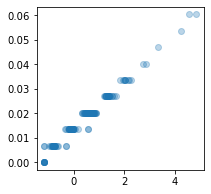

In [6]:
from os.path import exists

centrality = nx.degree_centrality
checkpoint_file = "degree_checkpoint_nogridandcaveman.pt"
# checkpoint = {
#     "epochs":500,
#     "optimizer":optimizer,
#     "losses":losses,
#     "model":lcm,
# }
if exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    epochs = checkpoint["epochs"]
    optimizer = checkpoint["optimizer"]
    losses = checkpoint["losses"]
    lcm = checkpoint["model"]
    
else:
    epochs = 0
    lcm = M5(n_output=1).to(device)
    optimizer = torch.optim.Adam(lcm.parameters(), lr=1e-5)
    losses = []


l=10000
sig = torch.zeros(l).to(device)
sig[0]=1
instrument = SignalPropagation(sig, momentum=0.999, response_len=10000, tqdm=lambda x:x,device=device).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # reduce the learning after 100 graphs by a factor of 10
criterion = torch.corrcoef
graphs_iter = graph_gen()

G = nx.gnm_random_graph(150,200)
print(eval_graph(G,instrument,lcm,centrality))
print("trained to epoch:",epochs)

lcm = lcm.train(True)


In [7]:
for checkpoints in range(0):
    #train
    for i in tqdm(range(epochs,epochs+50)): #epochs 
        Gs = [next(graphs_iter) for _ in range(1+i//10)]
        As = [nx.adjacency_matrix(G).toarray() for G in Gs]
        As = [torch.tensor(A).to(device) for A in As]

        with torch.no_grad():
            responses = [instrument(A) for A in As]

        AGRs = list(zip(As,Gs,responses))

        for _ in range(10+i//10): #graph steps
            loss = 0
            for A,G,R in AGRs: 
                y_pred = lcm(R.unsqueeze(dim=1).double())
                y_pred = y_pred.squeeze()

                y_gt = centrality(G)
                y_gt = [y_gt[i] for i in range(G.number_of_nodes())]
                y_gt = torch.tensor(y_gt).to(device)

                #loss = criterion(y_pred, y_gt)
                l = (1 - criterion(torch.stack((y_pred, y_gt), dim=0))[0,1])
                loss += l

            loss /= len(AGRs)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
    epochs = i

    #print loss
    nplosses = np.array(losses)
    plt.figure(figsize=(6,3))
    plt.semilogy(nplosses)

    #save checkpoint
    checkpoint = {
        "epochs":epochs,
        "optimizer":optimizer,
        "losses":losses,
        "model":lcm,
    }
    torch.save(checkpoint,checkpoint_file)

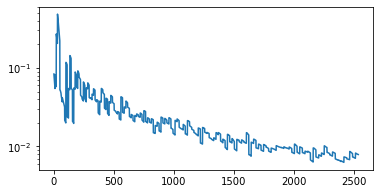

In [8]:
#print loss
nplosses = np.array(losses)
plt.figure(figsize=(6,3))
plt.semilogy(nplosses[:5000])


In [9]:
lcm = lcm.train() ##the model should not be set to eval mode to preserve the results

tensor([[1.0000, 0.9907],
        [0.9907, 1.0000]], device='cuda:0', dtype=torch.float64)


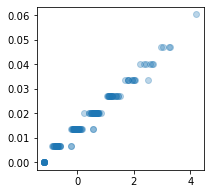

In [10]:
G=nx.gnm_random_graph(150,200)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9954],
        [0.9954, 1.0000]], device='cuda:0', dtype=torch.float64)


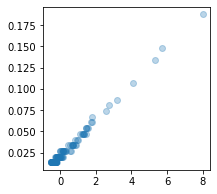

In [11]:
G = nx.barabasi_albert_graph(150,2)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9931],
        [0.9931, 1.0000]], device='cuda:0', dtype=torch.float64)


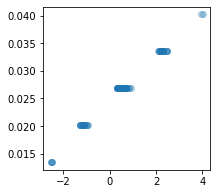

In [12]:
G = nx.watts_strogatz_graph(150,4,0.1)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9723],
        [0.9723, 1.0000]], device='cuda:0', dtype=torch.float64)


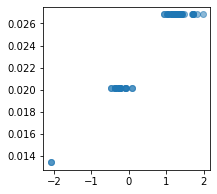

In [13]:
G = nx.grid_graph((10,15))
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9843],
        [0.9843, 1.0000]], device='cuda:0', dtype=torch.float64)


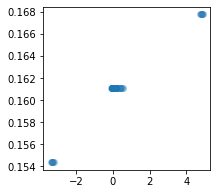

In [14]:
G = nx.connected_caveman_graph(6, 25)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9870],
        [0.9870, 1.0000]], device='cuda:0', dtype=torch.float64)


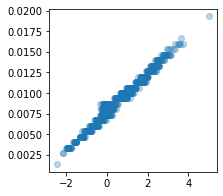

In [15]:
G = nx.gnm_random_graph(1500,10000)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9947],
        [0.9947, 1.0000]], device='cuda:0', dtype=torch.float64)


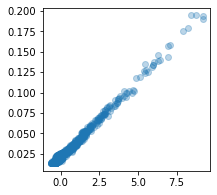

In [16]:
G = nx.barabasi_albert_graph(1500,20)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9868],
        [0.9868, 1.0000]], device='cuda:0', dtype=torch.float64)


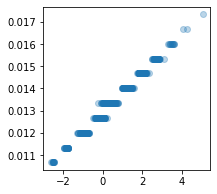

In [17]:
G = nx.watts_strogatz_graph(1500,20,0.1)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9460],
        [0.9460, 1.0000]], device='cuda:0', dtype=torch.float64)


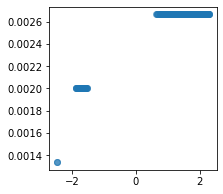

In [18]:
G = nx.grid_graph((30,50))
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9565],
        [0.9565, 1.0000]], device='cuda:0', dtype=torch.float64)


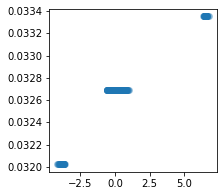

In [19]:
G = nx.connected_caveman_graph(30, 50)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9880],
        [0.9880, 1.0000]], device='cuda:0', dtype=torch.float64)


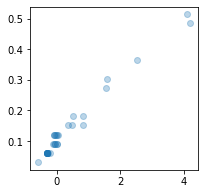

In [20]:
G = nx.karate_club_graph()
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9856],
        [0.9856, 1.0000]], device='cuda:0', dtype=torch.float64)


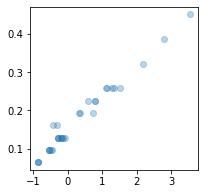

In [21]:
G = nx.davis_southern_women_graph()
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9897],
        [0.9897, 1.0000]], device='cuda:0', dtype=torch.float64)


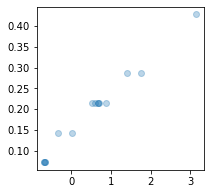

In [22]:
G = nx.florentine_families_graph()
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.8679],
        [0.8679, 1.0000]], device='cuda:0', dtype=torch.float64)


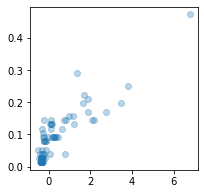

In [23]:
G = nx.les_miserables_graph()
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9931],
        [0.9931, 1.0000]], device='cuda:0', dtype=torch.float64)


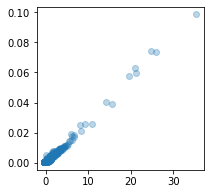

In [24]:
G = nx.random_internet_as_graph(4000)
print(eval_graph(G,instrument,lcm,centrality))

tensor([[1.0000, 0.9754],
        [0.9754, 1.0000]], device='cuda:0', dtype=torch.float64)


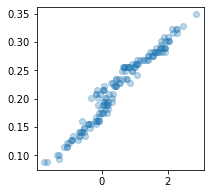

In [7]:
G = nx.random_geometric_graph(150,0.3,dim=2, pos=None, p=2, seed=None) 
print(eval_graph(G,instrument,lcm,centrality))